In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


In [24]:
import pandas as pd

cafe_df = pd.read_csv('auscafe.csv', parse_dates=['date'])
cafe = pd.Series(data=cafe_df['Y'].values, index=cafe_df['date'])

print(cafe.head())

date
1982-04-01    0.3424
1982-05-01    0.3421
1982-06-01    0.3287
1982-07-01    0.3385
1982-08-01    0.3315
dtype: float64


In [25]:
train_size = int(len(cafe) * 0.8)
train, test = cafe[:train_size], cafe[train_size:]


date
2010-08-01    2.8000
2010-09-01    2.7428
2010-10-01    2.7302
2010-11-01    2.6844
2010-12-01    3.0211
               ...  
2017-05-01    3.5986
2017-06-01    3.5442
2017-07-01    3.6981
2017-08-01    3.7112
2017-09-01    3.7297
Length: 86, dtype: float64

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

ses_model = SimpleExpSmoothing(train, initialization_method="estimated").fit()
ses_forecast = ses_model.forecast(len(test))

rmse = np.sqrt(mean_squared_error(test, ses_forecast))
print(f'RMSE: {rmse}')

mape = mean_absolute_percentage_error(test, ses_forecast)
print(f'MAPE: {mape}')

RMSE: 0.6370136261199998
MAPE: 0.15739416958699703


C:\Users\Julien\miniconda3\envs\PCD\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


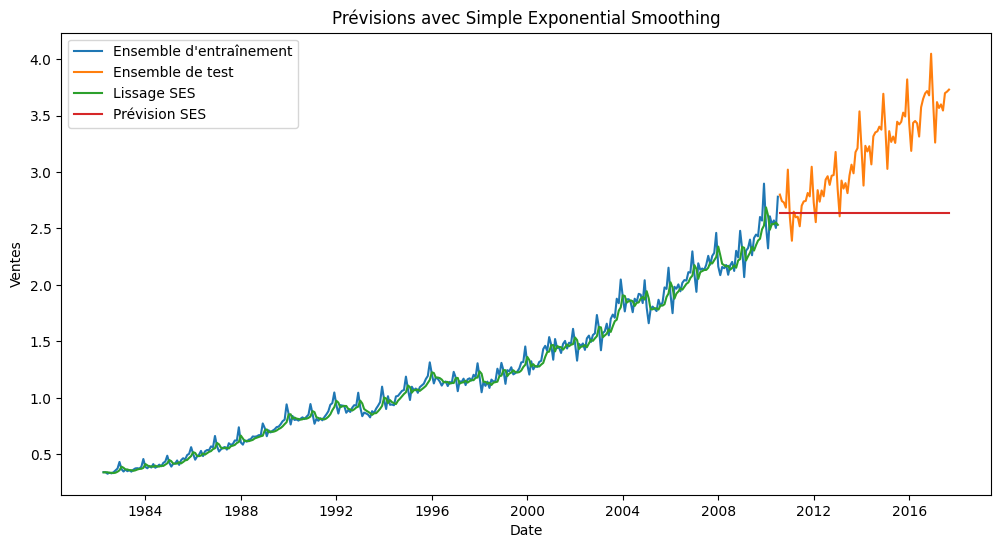

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train, label='Ensemble d\'entraînement')
plt.plot(test, label='Ensemble de test')
plt.plot(ses_model.fittedvalues, label='Lissage SES')
plt.plot(ses_forecast, label='Prévision SES')
plt.title('Prévisions avec Simple Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Ventes')
plt.legend()
plt.show()


In [64]:
from statsmodels.tsa.api import Holt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

def evaluate_holt(exponential, damped_trend):
    model = Holt(train, exponential=exponential, damped_trend=damped_trend, initialization_method="estimated").fit()
    forecast = model.forecast(len(test))
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mape = mean_absolute_percentage_error(test, forecast)
    return model, forecast, rmse, mape

combinations = [(False, False), (True, False), (False, True), (True, True)]
results = {}

for exp, damp in combinations:
    model, forecast, rmse, mape = evaluate_holt(exp, damp)
    key = f'exponential={exp}, damped_trend={damp}'
    results[key] = {'model': model, 'forecast': forecast, 'rmse': rmse, 'mape': mape}

for key, value in results.items():
    print(f'{key}: RMSE={value["rmse"]}, MAPE={value["mape"]}')


exponential=False, damped_trend=False: RMSE=0.32801563593851335, MAPE=0.07835393203077849
exponential=True, damped_trend=False: RMSE=0.277722651378503, MAPE=0.07341060723797674
exponential=False, damped_trend=True: RMSE=0.2865241193154332, MAPE=0.06783265691797068
exponential=True, damped_trend=True: RMSE=0.24410205582647906, MAPE=0.05831172534367675


C:\Users\Julien\miniconda3\envs\PCD\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Julien\miniconda3\envs\PCD\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Julien\miniconda3\envs\PCD\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Julien\miniconda3\envs\PCD\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [65]:
# Trouver la meilleure combinaison de paramètres
best_combination = min(results, key=lambda k: results[k]['rmse'])
best_model = results[best_combination]['model']
best_forecast = results[best_combination]['forecast']
best_rmse = results[best_combination]['rmse']
best_mape = results[best_combination]['mape']

print(f'La meilleure combinaison est: {best_combination}')
print(f'RMSE: {best_rmse}')
print(f'MAPE: {best_mape}')


La meilleure combinaison est: exponential=True, damped_trend=True
RMSE: 0.24410205582647906
MAPE: 0.05831172534367675


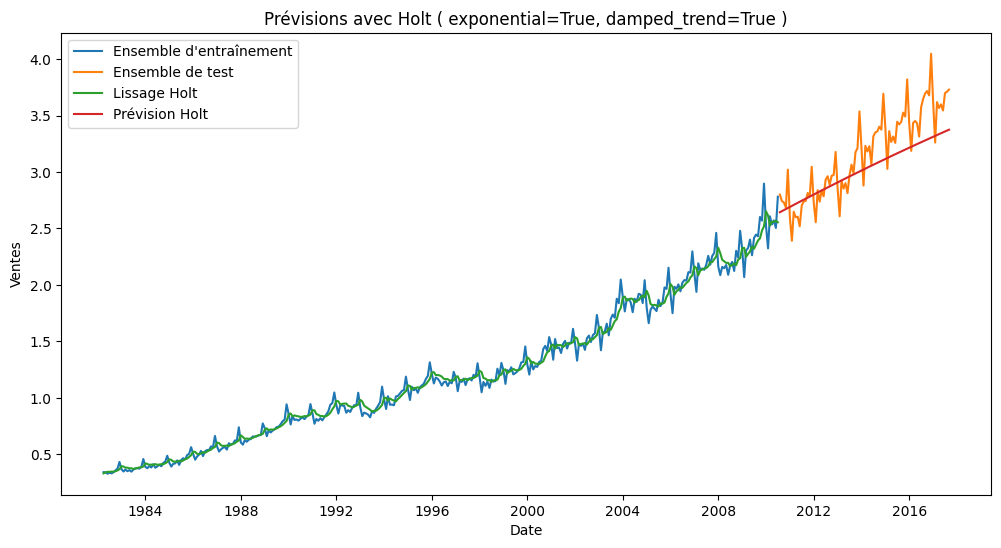

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train, label='Ensemble d\'entraînement')
plt.plot(test, label='Ensemble de test')
plt.plot(best_model.fittedvalues, label='Lissage Holt')
plt.plot(best_forecast, label='Prévision Holt')
plt.title(f'Prévisions avec Holt ( {best_combination} )')
plt.xlabel('Date')
plt.ylabel('Ventes')
plt.legend()
plt.show()
